## Sentiment Prediction using Random Forest Classifier & SVM

In [380]:
import spacy
import sklearn
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.dummy import DummyClassifier

# Load pre-processed data
df = pd.read_csv("data/all_cleaned_alt")
df.sample(3)


,stars,title,text,text_clean,sentiment,text_sid_vader_neg,text_sid_vader_neu,text_sid_vader_pos,text_sid_vader_compound,text_sid_textblob_polarity
3197,3,Good but not the best,"It's a good app , and all of the people using ...",it a good app and all of the peopl use this bu...,neutral,0.184,0.606,0.210,-0.0905,0.850000
830,4,Their support team is amazing,Their support team is amazing! I had a problem...,their support team is amaz i had a problem wit...,positive,0.090,0.820,0.090,0.0000,0.208333
1254,5,Excellent VPN with Helpful Customer Support,probably the best price-to-performance VPN in ...,probabl the best price-to-perform vpn in the m...,positive,0.000,0.588,0.412,0.9118,1.000000


#### Quick bucket size check

In [381]:
df["sentiment"].value_counts(normalize=True)

negative    0.333333
positive    0.333333
neutral     0.333333
Name: sentiment, dtype: float64

#### Downloading large spacy model (~700 MB)

In [372]:
%%capture
!python -m spacy download en_core_web_lg

#### Tokenizing, cleaning and vectorizing data with spaCy (1-2 mins)

In [382]:
nlp = spacy.load('en_core_web_lg')

def clean_text(text):
    doc = nlp(text)
    tokens = [
                token.lemma_.lower() for token in doc if
                token.is_stop == False and
                token.is_oov == False and
                token.is_alpha == True
             ]
    return " ".join(tokens)

def vectorize_text(text):
    doc = nlp(text)
    return doc.vector

df['text_clean_alt'] = df['text'].apply(clean_text)
df['text_vector'] = df['text_clean_alt'].apply(vectorize_text)
df.head()

,stars,title,text,text_clean,sentiment,text_sid_vader_neg,text_sid_vader_neu,text_sid_vader_pos,text_sid_vader_compound,text_sid_textblob_polarity,text_clean_alt,text_vector
0,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...,with just one devic connect 4g speed 90mbps do...,negative,0.050,0.934,0.016,-0.4497,-0.075556,device connect speed g speed plummet ping usa ...,"[0.056637626, 0.22103043, -0.13658734, 0.02172..."
1,1,Very Slow,Very Slow - avoid this company Recently signed...,veri slow avoid this compani recent sign up af...,negative,0.017,0.828,0.154,0.9294,0.089815,slow avoid company recently sign change large ...,"[-0.13510671, 0.18857293, -0.29241022, 0.05847..."
2,2,Underwhelming service and functionality,I have been using the service for about 3 mont...,i have been use the servic for about 3 month g...,negative,0.127,0.804,0.069,-0.6496,0.080000,service month generally work ok compare servic...,"[-0.005651634, 0.18382417, -0.086369626, -0.07..."
3,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...,i can't wait to switch vpns everi time my pc a...,negative,0.105,0.870,0.025,-0.8126,-0.012500,wait switch vpn time pc automatically update b...,"[0.0832851, 0.08178967, -0.12454006, 0.0198281..."
4,1,Horrible,Horrible. Beware!! I signed up and after m...,horribl bewar i sign up and after multipl atte...,negative,0.048,0.884,0.068,0.5267,-0.145833,horrible beware sign multiple attempt able con...,"[-0.09164358, 0.07996366, -0.31383055, 0.04610..."


#### Training models and evaluating them (Random Forest Classifier & Support Vector Machine)

In [383]:
# Features & Target
X = df['text_vector'].tolist()
Y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [411]:
# Fit & predict 
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.76      0.77      0.77       243
     neutral       0.74      0.74      0.74       227
    positive       0.89      0.88      0.88       252

    accuracy                           0.80       722
   macro avg       0.80      0.80      0.80       722
weighted avg       0.80      0.80      0.80       722



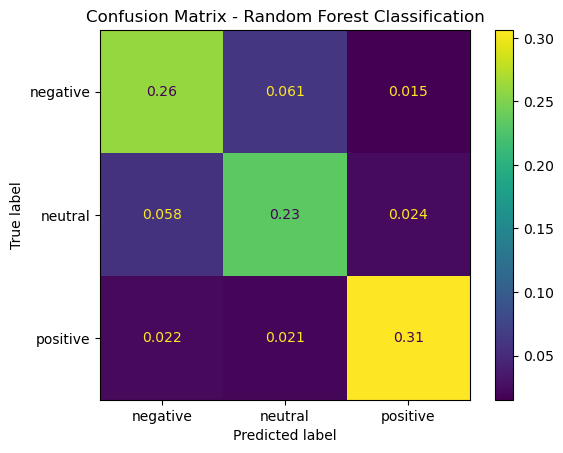

In [412]:
# Confusion matrix of the first model
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Random Forest Classification")
plt.show()

In [418]:
# Fit & predict
svm_clf = SVC(C=10, degree=2, gamma='scale', kernel='rbf', class_weight=None, random_state=1)
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)

# Classification metrics
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.73      0.81      0.77       243
     neutral       0.76      0.72      0.74       227
    positive       0.93      0.89      0.91       252

    accuracy                           0.81       722
   macro avg       0.81      0.80      0.81       722
weighted avg       0.81      0.81      0.81       722



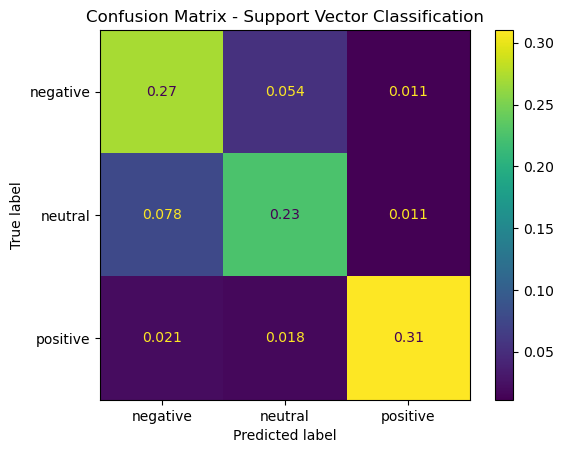

In [419]:
# Confusion matrix of the second model
ConfusionMatrixDisplay.from_estimator(svm_clf, X_test, y_test, normalize="all")
plt.title("Confusion Matrix - Support Vector Classification")
plt.show()

In [420]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Calculate the accuracy for the dummy and both models
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Dummy accuracy:", accuracy_dummy)
print("Random Forest accuracy:", accuracy_rf)
print("Support Vector Machine accuracy:", accuracy_svm)

Dummy accuracy: 0.314404432132964
Random Forest accuracy: 0.7991689750692521
Support Vector Machine accuracy: 0.8074792243767313


#### Hyperparameter tuning (Random Forest Classifier)

In [23]:
# Tuning model using RandomizedSearchCV
param_dist = {
            'n_estimators': randint(50, 200),
            'max_depth': randint(2, 8),
            'min_samples_split': randint(2, 6),
            'min_samples_leaf': randint(1, 4)
             }

random_search = RandomizedSearchCV(rf_clf, param_distributions=param_dist, n_iter=50, cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)


Best hyperparameters:  {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 121}


In [260]:
# Tuning model using GridSearchCV
param_grid = {
            'n_estimators': [121],
            'max_depth': [7],
            'min_samples_split': [5],
            'min_samples_leaf': [3],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]
             }
              
grid_search = GridSearchCV(rf_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'bootstrap': False, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 121}


#### Hyperparameter tuning (Support Vector Machine)

In [24]:
# Tuning model using RandomizedSearchCV
param_dist = {
            'C': uniform(0, 100), 
            'kernel': ['linear', 'rbf', 'poly'], 
            'degree': range(2, 6), 
            'gamma': ['scale', 'auto']
             }

random_search = RandomizedSearchCV(svm_clf, param_distributions=param_dist, n_iter=50, cv=5)
random_search.fit(X_train, y_train)

print("Best hyperparameters: ", random_search.best_params_)

Best hyperparameters:  {'C': 9.985439082465788, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [271]:
# Tuning model using GridSearchCV
param_grid = {
            'C': [10, 30, 50, 70, 90],
            'kernel': ['rbf'],
            'degree': [2],
            'gamma': ['scale'],
            'class_weight': ['balanced', None],
            'random_state': [1, 42, 100, None]
             }
              
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 1}


#### Export the trained models

In [421]:
joblib.dump(rf_clf, 'trained_models/rf_trained.pkl')
joblib.dump(svm_clf, 'trained_models/svm_trained.pkl')

['trained_models/svm_trained.pkl']

#### Load the trained models and test them

In [422]:
# Checking text pre-processing and vectorization on example reviews
test_review = "I can't believe I have wasted !!! so much money 123 on VPN. Very bad $$ service. Never again."

test_clean = clean_text(test_review)
print(test_clean)

vector = vectorize_text(test_clean).reshape(1, -1)
print(vector.shape)

# Feel free to take one of these reviews for testing
# ---
# I have 3 ALexas at home!! Get very good soon what love all of them amazing stuff! \U0001F600-\U0001F64F amazon.com
# I can't believe I have wasted !!! so much money 123 on VPN. Very bad $$ service. Never again.
# I absolutely *** hate Apple! Their customer support is the worst!
# I absolutely $$ the at a love Google!!1 They wadawd 123 3124 $$ are the best!
# 

believe waste money vpn bad service
(1, 300)


In [441]:
rf_trained = joblib.load("trained_models/rf_trained.pkl")
svm_trained = joblib.load("trained_models/svm_trained.pkl")

test_input = input("Enter your review: ")
test_review_vector = vectorize_text(clean_text(test_input)).reshape(1, -1)

prediction_rf = rf_trained.predict(test_review_vector)
prediction_svm = svm_trained.predict(test_review_vector)

print("Review: "+test_input+"\n")
print("RF model sentiment prediction: ", prediction_rf)
print("SVM model sentiment prediction: ", prediction_svm)

Review: Useful music app that has a wide range available on its app, the ads aren't as much of an issue on the free version its pretty fair and the premium is a reasonable price. Recent updates have bugged out the site tho as thats why its no longer a 5, issues with the playlist and friends feed setting.

RF model sentiment prediction:  ['neutral']
SVM model sentiment prediction:  ['neutral']
